# 1  Скачивание, обработка и визуализация данных

## Базовая настройка проекта

In [17]:
import numpy as np
import matplotlib
from pyquery import PyQuery as pq
from matplotlib import pylab as plt
plt.rcParams.update({'font.size': 28})
matplotlib.rcParams.update({'font.size': 40})

%matplotlib inline
%config InlineBackend.figure_format = "svg"
%config InlineBackend.close_figures = True

## Скачиваем данные за 1978  -- 2015

In [18]:
# Загрузка данных
def load_data(data_file: "html", ret_flag: int=0)->tuple:
    """
    Считывание данных из файла, удаление заголовков 
    и разбиение данных на дату и координаты
    """
    text = [item.text() for item in data_file.items("pre")]
    text = text[0].split()
    text = text[3:] # del table 
    del(text[2::3]) # del sigma from data
    
    date = np.array(text[0::2]).astype(float) # convert str to int
    
    data_value = np.array(text[1::2]).astype(float) # convert str value to float
    
    if ret_flag:
        return data_value, date
    return data_value

In [19]:
x_data = pq(filename="data_html/datax_1978.html")
y_data = pq(filename="data_html/datay_1978.html")

x_coord, date = load_data(x_data, 1)
y_coord = load_data(y_data)

### Построим полученные данные

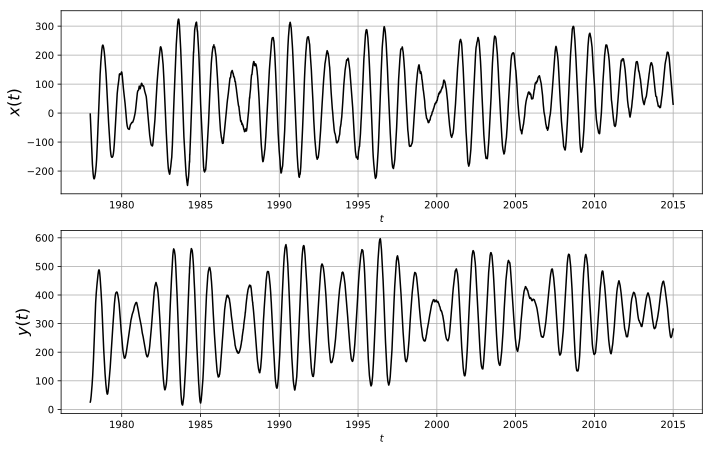

In [30]:
ax = plt.figure(figsize=(11.5, 15.5))
plt.subplot(4,1,1)
plt.grid(True)
plt.ylabel("$x(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
# plt.legend()

plt.subplot(4,1,2)
plt.grid(True)
plt.ylabel("$y(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(date, y_coord, color="black", label="$y(t)$")
# plt.legend()

plt.savefig("./figures/section1/x_and_y.eps", format="eps" ,bbox_inches='tight')
plt.show()

##  Удаления тренда и гармоник с $h < 7 $ лет

In [31]:
# удалим тренд
A_coord = np.vstack([date, np.ones(len(date))]).T
a_x, b_x = np.linalg.lstsq(A_coord, x_coord, rcond=None)[0]
a_y, b_y = np.linalg.lstsq(A_coord, y_coord, rcond=None)[0]
print("a_x = {}, b_x = {}".format(a_x, b_x))
print("a_y = {}, b_y = {}".format(a_y, b_y))
trend_x = a_x * date + b_x
trend_y = a_y * date + b_y
detrend_x = x_coord - trend_x
detrend_y = y_coord - trend_y

a_x = 1.9936878932906148, b_x = -3931.7921571122347
a_y = 2.2488005758509213, b_y = -4168.697309332524


### Визуализируем тренд

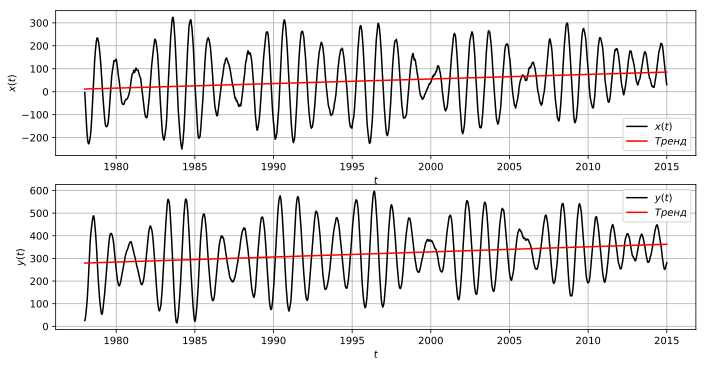

In [32]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$x(t)$")
plt.xlabel("$t$")
plt.plot(date, x_coord, color="black", label="$x(t)$")
plt.plot(date, trend_x, color="red", label="$Тренд$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$y(t)$")
plt.xlabel("$t$")
plt.plot(date, y_coord, color="black", label="$y(t)$")
plt.plot(date, trend_y, color="red", label="$Тренд$")
plt.legend()

plt.savefig("./figures/section1/x_and_y_with_trend.eps", format="eps",bbox_inches='tight')
plt.show()

### Выгрузим данные для удаления шумов в Автосигнале

In [33]:
with open("data_txt/detrend_x_1.txt", 'w') as datatxt:
    for i in range(len(x_coord)) :
        print(date[i], '\t', detrend_x[i], file=datatxt)
with open("data_txt/detrend_y_1.txt", 'w') as datatxt:
    for i in range(len(y_coord)) :
        print(date[i], '\t', detrend_y[i], file=datatxt)

### Загружем отфильрованные данные

In [34]:
with open("data_txt/fx_1.txt", 'r') as data_x_txt:
    data = data_x_txt.read()
    data = data.split()
    filtred_x = np.array(data[1::2]).astype(np.float32)
    filtred_date = np.array(data[0::2]).astype(np.float32)
    print(filtred_x.shape, filtred_date.shape)
with open("data_txt/fy_1.txt", 'r') as data_y_txt:
    data = data_y_txt.read()
    data = data.split()
    filtred_y = np.array(data[1::2]).astype(np.float32)
    print(filtred_y.shape)

(13514,) (13514,)
(13514,)


### Построим отфильтованные данные

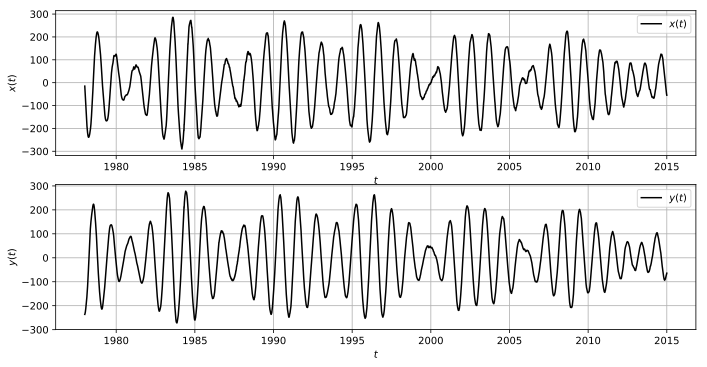

In [35]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$x(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, filtred_x, color="black", label="$x(t)$")
plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$y(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, filtred_y, color="black", label="$y(t)$")
plt.legend()
# plt.savefig("./figures/x_and_y_filtred.eps", format="eps")
plt.show()

# 2 Переходим к полярному углу

## Зададим функцию перехода 

In [36]:
def polar_coordinate_system(x: "np.array", y: "np.array"):
    r = np.sqrt(x ** 2 + y ** 2)
#     phi = [np.arctan(y[0] / x[0]) + np.pi]
    phi = [0]
    for i in range(len(r) - 1):
        delta_x = x[i + 1] - x[i]
        delta_y = y[i + 1] - y[i]
        delta_r = np.sqrt(delta_x ** 2 + delta_y ** 2)
        delta_phi = np.arccos(np.minimum(1,(r[i + 1] ** 2 + r[i] ** 2 - delta_r ** 2)/
                              (2 * r[i + 1] * r[i])))
        k = (x[i] * (y[i] - y[i - 1]) - y[i] * (x[i] - x[i - 1]))
        k /= np.abs(k)
        phi.append(phi[i] + delta_phi * k)

    return r, phi

## найдем пол-е коор-ы для наших обработанных данных

In [37]:
r, phi = polar_coordinate_system(filtred_x, filtred_y)
print(np.shape(r), np.shape(phi), np.shape(filtred_date))

(13514,) (13514,) (13514,)


### Визуализируем

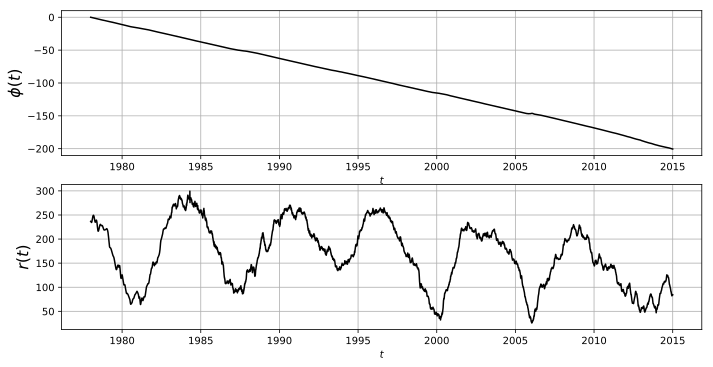

In [40]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$\phi(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(filtred_date, phi, color="black", label="$\phi(t)$")
# plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$r(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(filtred_date, r, color="black", label="$r(t)$")
# plt.legend()
plt.savefig("./figures/section1/polar.eps", format="eps",bbox_inches='tight')
plt.show()

## Удалим линейную состовляющую
$\phi(t)'= at + b$

In [41]:
A = np.vstack([filtred_date, np.ones(len(date))]).T
a, b = np.linalg.lstsq(A, phi, rcond=None)[0]
print("a = {}, b = {}".format(a, b))
trend = a * filtred_date + b
detrend_phi = phi - trend

a = -5.299376467883496, b = 10482.604419351686


### Визуализируем

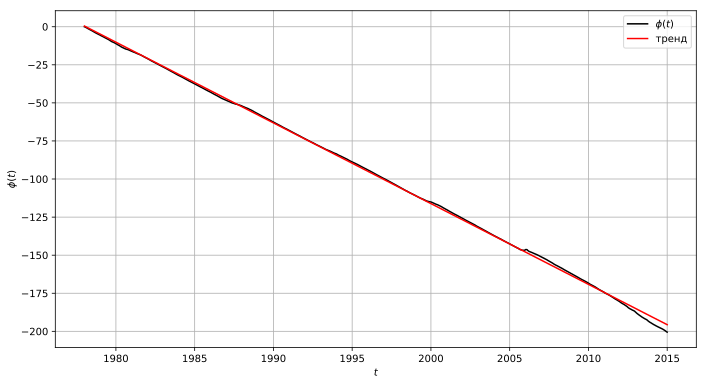

In [42]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.plot(filtred_date, phi, color="black", label="$\phi(t)$")
plt.plot(filtred_date, trend, color="red", label="тренд")
plt.legend()
plt.show()

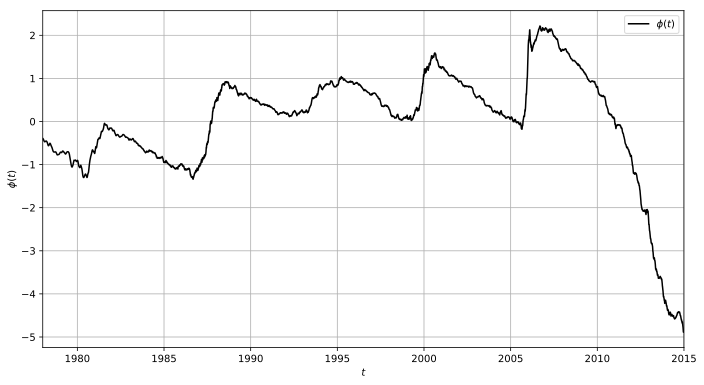

In [43]:
plt.figure(figsize=(11.5, 6.2))
plt.grid(True)
plt.ylabel("$\phi(t)$")
plt.xlabel("$t$")
plt.xlim(filtred_date[0], filtred_date[-1])
plt.plot(filtred_date, detrend_phi, color="black", label="$\phi(t)$")
plt.savefig("./figures/section1/polar_detrend.eps", format="eps", bbox_inches='tight')
plt.legend()
plt.show()

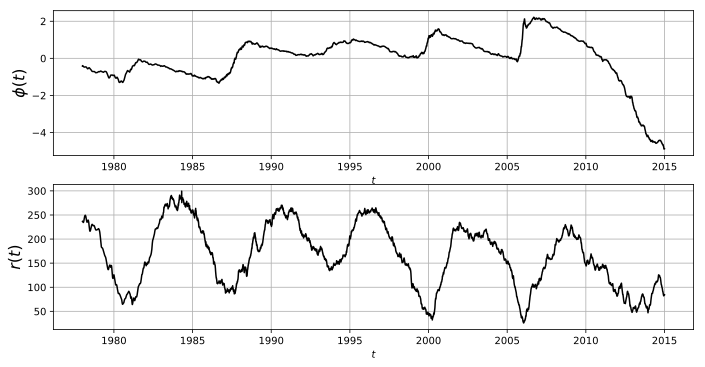

In [48]:
plt.figure(figsize=(11.5, 15.5))
plt.subplot(5,1,1)
plt.grid(True)
plt.ylabel("$\phi(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(filtred_date, detrend_phi, color="black", label="$\phi(t)$")
# plt.legend()

plt.subplot(5,1,2)
plt.grid(True)
plt.ylabel("$r(t)$", fontsize=16)
plt.xlabel("$t$")
plt.plot(filtred_date, r, color="black", label="$r(t)$")
# plt.legend()
plt.savefig("./figures/section1/polar_deter_pres.eps", format="eps",bbox_inches='tight')
plt.show()

# Выгрузка данных для дальнейшей работы


In [45]:
with open("data_txt/section1end.txt", 'w') as datatxt:
    for i in range(len(x_coord)) :
        print(filtred_date[i], '\t', detrend_phi[i], file=datatxt)

In [46]:
with open("data_txt/section1end_nofil.txt", 'w') as datatxt:
    for i in range(len(x_coord)) :
        print(filtred_date[i], '\t', phi[i], file=datatxt)